<a href="https://colab.research.google.com/github/Brene-m/call_volume_forecast_model_with_deep_learning.ipynb/blob/main/Call_Volume_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MTOTO NEWS CHILDLINE KENYA CALL VOLUME PREDICTION

AUTHORS


1.   Annastasiah Muchau
2.   Patriciah Mboya
3.   Irene Maina
4.   Keith Maina
5.   Faith Leo
6.   John Konoru



## **1.0 BUSINESS UNDERSTANDING**

### 1.1  Business Question
As a result of an increased number of reported cases on child abuse, there is a dire need to have prompt responses. It is crucial that reported cases are acted upon promptly to ensure timely and efficient handling of reported cases.
The stakeholders are Mtoto News, a digital company that leverages on technology to improve child wellbeing, and Childline Kenya, an NGO established in response to the state of child protection in Kenya and the manner in which abuse cases were being reported and handled.








### 1.2 Main objective
Building a forecast model that predicts the number of incoming calls that Childline Kenya will receive per hour per day..

### 1.3 Metric of success
The algorithm will be considered a success if the predictions made by it has a:

RMSE of between 20-25

## **2.0 DATA UNDERSTANDING**

### 2.1 The Dataset

The dataset is provided on [Zindi Africa](https://zindi.africa/competitions/mtoto-news-childline-kenya-call-volume-prediction-challenge), the training data contains all the calls (over 135,000) that were received from 1 January 2016 to 12 July 2016.

Each call contains the following fields:

- calldate - Date (month-day-year) and time of the call

- cc_status - Case status

- maincat - Main category call falls into

- subcat1 - Subcategory call falls under

- casepriority - Priority of the case

- referal -  Place case referred to

- caller_gender - Gender of the caller

- caller_age - Age of the caller

- caller_county - Area where the call came from

- child_age - Age of the child in case

- child_gender - Gender of the child in case

- child_county - Area where the child is from

- parent_age - Age of the parent

- parent_gender - Gender of the parent

- parent_county - Area where the child is from

- Abuser_Relationship - Relationship abuser has with the child in case

- Neglector_Relationship - Relationship neglector has with the child in case

- Physical_abuser_Relationship - Relationship physical abuser has with the child in case.

An explanation of all the columns of the weather data can be found <a href= "https://rp5.ru/Weather_archive_in_Nairobi_(airport)">here</a>

## **3.0 DATA PREPARATION**

### 3.1 Loading libraries

Connecting to Google drive and Importing all the necessary Libraries | Modules.

In [ ]:
#connecting collab to google drive 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import all the relevant libraries

import pandas as pd
import numpy as np
import os, shutil
import warnings 
warnings.filterwarnings('ignore')

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#modeling libraries
from math import sqrt
from sklearn.metrics import mean_squared_error
from datetime import timedelta, datetime
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from fbprophet.diagnostics import cross_validation
from statsmodels.tsa.statespace.sarimax import SARIMAX
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)



### 3.2 Loading the data

The data was loaded using `os.listdir` method

In [ ]:
# print the contents of the mtoto news childline kenya folder 

print(os.listdir('/content/drive/Shareddrives/Eagles/mtoto_news_childline_kenya'))

['NairobiSchoolDates2016.csv', 'Sample_Submission.csv', 'KenyaPublicHolidays2016.csv', 'train.csv', 'WeatherNairobi2016.xlsx', 'train.gsheet']


In [ ]:
#store the file paths as variables

weather_file = ('/content/drive/Shareddrives/Eagles/mtoto_news_childline_kenya/WeatherNairobi2016.xlsx')
dates_file = ('/content/drive/Shareddrives/Eagles/mtoto_news_childline_kenya/NairobiSchoolDates2016.csv')
holidays_file = ('/content/drive/Shareddrives/Eagles/mtoto_news_childline_kenya/KenyaPublicHolidays2016.csv')
train_file = ('/content/drive/Shareddrives/Eagles/mtoto_news_childline_kenya/train.csv')

View contents of the files

In [ ]:
#print the data in the train file 

train_data = pd.read_csv(train_file)
train_data.head(3)

calldate cc_status             maincat     subcat1  \
0  2016-01-01 07:26:47    Closed  non-interventional  Blank call   
1  2016-01-01 07:32:30    Closed  non-interventional  Blank call   
2  2016-01-01 07:44:31    Closed  non-interventional  Blank call   

   casepriority referal caller_gender caller_age caller_county child_age  \
0  Non Critical     NaN           NaN        NaN           NaN       NaN   
1  Non Critical     NaN           NaN        NaN           NaN       NaN   
2  Non Critical     NaN           NaN        NaN           NaN       NaN   

  child_gender child_county parent_age parent_gender parent_county  \
0          NaN          NaN        NaN           NaN           NaN   
1          NaN          NaN        NaN           NaN           NaN   
2          NaN          NaN        NaN           NaN           NaN   

  Abuser_Relationship Neglector_Relationship Perpetrator_Relationship  \
0                 NaN                    NaN                      NaN   
1                 NaN                    NaN                      NaN   
2                 NaN                    NaN                      NaN   

  Physical abuser_Relationship  
0                          NaN  
1                          NaN  
2                          NaN

In [ ]:
#print the data in the dates file 

date_data = pd.read_csv(dates_file)
date_data.head(3)

Term     Opening     Closing  Unnamed: 3  Unnamed: 4  \
0     1  2016-01-04  2016-04-08         NaN         NaN   
1     2  2016-05-02  2016-08-05         NaN         NaN   
2     3  2016-09-05  2016-11-18         NaN         NaN   

                                          Unnamed: 5  
0                                    *year/month/day  
1  https://www.standardmedia.co.ke/article/200018...  
2                                                NaN

In [ ]:
#print the data in the holidays file 

holiday_data = pd.read_csv(holidays_file, skiprows= 2)
holiday_data.head()

Date              Holiday Unnamed: 2
0  2016/01/01        New Years Day        NaN
1  2016/03/25          Good Friday        NaN
2  2016/03/28        Easter Monday        NaN
3  2016/05/01           Labour Day        NaN
4  2016/05/02  Labour Day observed        NaN

In [ ]:
# uncomment following line to install pandas update of xlrd
# !pip install --upgrade xlrd
weather_data= pd.read_excel(weather_file, skiprows= 6)

In [ ]:
weather_data.head()

Local time in Nairobi (airport)     T  Po   P  Pa     U  \
0                31.12.2016 21:00  20.2 NaN NaN NaN  68.0   
1                31.12.2016 15:00  26.0 NaN NaN NaN  40.0   
2                31.12.2016 09:00  18.8 NaN NaN NaN  85.0   
3                30.12.2016 21:00  19.5 NaN NaN NaN  79.0   
4                30.12.2016 15:00  24.5 NaN NaN NaN  56.0   

                                      DD   Ff  ff10  ff3  ...  \
0   Wind blowing from the east-northeast  8.0   NaN  NaN  ...   
1       Wind blowing from the north-east  9.0   NaN  NaN  ...   
2  Wind blowing from the north-northeast  5.0   NaN  NaN  ...   
3   Wind blowing from the east-northeast  4.0   NaN  NaN  ...   
4   Wind blowing from the east-northeast  7.0   NaN  NaN  ...   

                                             Cm  \
0   Altocumulus translucidus at a single level.   
1  No Altocumulus, Altostratus or Nimbostratus.   
2   Altocumulus translucidus at a single level.   
3   Altocumulus translucidus at a single level.   
4   Altocumulus translucidus at a single level.   

                                         Ch    VV    Td  \
0  No Cirrus, Cirrocumulus or Cirrostratus.  30.0  14.0   
1  No Cirrus, Cirrocumulus or Cirrostratus.  30.0  11.2   
2  No Cirrus, Cirrocumulus or Cirrostratus.  25.0  16.2   
3  No Cirrus, Cirrocumulus or Cirrostratus.  20.0  15.8   
4      Cirrus spissatus cumulonimbogenitus.  30.0  15.1   

                      RRR    tR   E  Tg  E' sss  
0                     NaN   NaN NaN NaN NaN NaN  
1                     NaN   NaN NaN NaN NaN NaN  
2  Trace of precipitation  24.0 NaN NaN NaN NaN  
3                     NaN   NaN NaN NaN NaN NaN  
4                     NaN   NaN NaN NaN NaN NaN  

[5 rows x 29 columns]

In [ ]:
train_data['maincat'].unique()

array(['non-interventional', 'others', 'general_information',
       'family_community_society', 'health_basic_needs', 'sexuality',
       'abuse', 'education_career'], dtype=object)

### 3.3 Data Cleaning

#### 3.3.0 Train data Cleaning

Checking for 

1.   Validity
2.   Completenes
3.   Consistency
4.   Uniformity



##### 3.3.1 Data Validity


*   Checking for the validity of data in the train_data
*   Removing  irrelevant columns 
*   Merging columns with same information 



In [ ]:
# remove the last column since it has irrelevant info
holiday_data.drop('Unnamed: 2',axis= 1, inplace= True)

In [ ]:
holiday_data.head()

Date              Holiday
0  2016/01/01        New Years Day
1  2016/03/25          Good Friday
2  2016/03/28        Easter Monday
3  2016/05/01           Labour Day
4  2016/05/02  Labour Day observed

In [ ]:
# remove the last 3 columns since they have irrelevant info
cols_to_drop= ['Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5']
date_data.drop(cols_to_drop,axis= 1, inplace= True)

##### 3.3.2 Uniformity

*   Checking different columns to ensure that they are correct.
*   Deleteing columns with duplicate entries



In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135988 entries, 0 to 135987
Data columns (total 19 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   calldate                      135988 non-null  object
 1   cc_status                     135988 non-null  object
 2   maincat                       135988 non-null  object
 3   subcat1                       135988 non-null  object
 4   casepriority                  135988 non-null  object
 5   referal                       1262 non-null    object
 6   caller_gender                 11548 non-null   object
 7   caller_age                    10732 non-null   object
 8   caller_county                 8667 non-null    object
 9   child_age                     3979 non-null    object
 10  child_gender                  3992 non-null    object
 11  child_county                  3749 non-null    object
 12  parent_age                    33 non-null      object
 13 

We noticed that in the referal column a lot of the values of the columns are similar both in the text and meaning. We therefore merge the similar values while also rectifying spelling errors.

In [ ]:
# merge values similar to children office
similar_to_children_law= ["Childrens", "Childrens Office", "Children's court", "Children's office", "CHILDREN", "Childrens'Court", "children's office", "Children's", "Child",
                          "Childrens officer", "Childrens office", "children's court", "Children's Court", "Childrens court", "children Officer"]
train_data['referal']= train_data['referal'].map(lambda x: 'children office/court' if x in similar_to_children_law else x)

# merge values similar to chief office
similar_to_chief_office= ["Chief's", "Chief's office", "Chief's Office", "Kenya", "Kenya Police", "kenya Police", "chief's office", "Chief officer",
                          "Chief", "Police station", "DO's", "Assistant county commisioners(DOs)"]
train_data['referal']= train_data['referal'].map(lambda x: 'chief/police office' if x in similar_to_chief_office else x)

# merge values similar to OVC rescue centre
similar_to_OVC= ["Children and rescuing centre(OVC)", "Children's rescuing Center(OVC)", "children's rescuing Center(OVC)", "children's rescuing center(OVC)", "OVC"]
train_data['referal']= train_data['referal'].map(lambda x: 'OVC rescue' if x in similar_to_OVC else x)

# similar to constituency fund
similar_to_constituency= ["Constituency", "Constituency Development  Fund(CDF)"]
train_data['referal']= train_data['referal'].map(lambda x: 'constituency dev fund' if x in similar_to_constituency else x)

# similar to education office
similar_to_ed= ["Education", "Education Office"]
train_data['referal']= train_data['referal'].map(lambda x: 'education office' if x in similar_to_ed else x)

# similar to youth hotline
similar_to_youth_hotline= ["Youth", "Youth Hotline 1190", "Youth hotline 1190"]
train_data['referal']= train_data['referal'].map(lambda x: 'youth hotline 1190' if x in similar_to_youth_hotline else x)

# fix a spelling error in 'child welfare sociaty'
train_data['referal']= train_data['referal'].map(lambda x: 'child welfare society' if x == 'child welfare sociaty' else x)

In [ ]:
# checking that the values have been changed
train_data['referal'].value_counts()

children office/court                                 788
chief/police office                                   318
Hospital                                               38
constituency dev fund                                  38
education office                                       25
youth hotline 1190                                     22
OVC rescue                                              8
CRADDLE                                                 4
GENDER                                                  4
FIDA                                                    3
Area                                                    2
CLAN                                                    1
child welfare society                                   1
Charitable                                              1
Amani                                                   1
World                                                   1
Save                                                    1
CARE          

We repeat the process for any other columns with the same issue.

In [ ]:
# fixing a capitalisation issue in casepriority
train_data['casepriority']= train_data['casepriority'].map(lambda x: 'Non Critical' if x == 'non Critical' else x)

In [ ]:
# fixing a spelling error in subcategory1
train_data['subcat1']= train_data['subcat1'].map(lambda x: 'Children rights/ issues' if x == 'Childrenï¿½s rights/ issues' else x)

In [ ]:
# fixing a typo in the age columns
train_data['caller_age']= train_data['caller_age'].map(lambda x: '11-15' if x == '2016-11-15 00:00:00' else x)
train_data['caller_age']= train_data['caller_age'].map(lambda x: '6-10' if x == '2016-06-10 00:00:00' else x)


In [ ]:
# combine the 10-15 and 11-15 values
train_data['child_age']= train_data['child_age'].map(lambda x: '11-15' if (x== '2016-11-15 00:00:00' or x== '2016-10-15 00:00:00' or x==' 11-15') else x)
train_data['child_age']= train_data['child_age'].map(lambda x: '6-10' if x == '2016-06-10 00:00:00' else x)

In [ ]:
# removing the distinction btwn certain texts that mean the same thing in the abuser relationship column
train_data['Abuser_Relationship']= train_data['Abuser_Relationship'].map(lambda x: 'Neighbor' if (x== 'Neighbour' or x== 'Neigbour') else x)
train_data['Abuser_Relationship']= train_data['Abuser_Relationship'].map(lambda x: 'Father' if x== 'father' else x)
train_data['Abuser_Relationship']= train_data['Abuser_Relationship'].map(lambda x: 'Unknown' if (x== 'Unspecified relationship' or x== 'unknown' or x== 'Undisclosed relationship' or x== 'Concerned') else x)
train_data['Abuser_Relationship']= train_data['Abuser_Relationship'].map(lambda x: 'Parent' if x== 'Parents' else x)
train_data['Abuser_Relationship']= train_data['Abuser_Relationship'].map(lambda x: 'Uncle' if x== 'Uncles' else x)
train_data['Abuser_Relationship']= train_data['Abuser_Relationship'].map(lambda x: 'Extended' if x== 'Extended Family' else x)
train_data['Abuser_Relationship']= train_data['Abuser_Relationship'].map(lambda x: 'Teacher' if x== 'Student' else x)
train_data['Abuser_Relationship']= train_data['Abuser_Relationship'].map(lambda x: 'Romantic Partner' if (x== 'Romantic parner' or x== 'Partner') else x)

In [ ]:
# removing distinctions in the neglector relationship column
train_data['Neglector_Relationship']= train_data['Neglector_Relationship'].map(lambda x: 'Parent' if x== 'Parents' else x)
train_data['Neglector_Relationship']= train_data['Neglector_Relationship'].map(lambda x: 'Father' if x== 'father' else x)
train_data['Neglector_Relationship']= train_data['Neglector_Relationship'].map(lambda x: 'GrandMother' if x== 'Grandmother' else x)
train_data['Neglector_Relationship']= train_data['Neglector_Relationship'].map(lambda x: 'Step-Mother' if x== 'Step mother' else x)

In [ ]:
# removing distinctions in the perpertrator relationship column
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Father' if (x== 'father' or x== 'Father ') else x)
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Mother' if (x== 'mother' or x== 'mother ') else x)
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Neighbor' if (x== 'neighbor' or x== 'neighbour' or x== 'Neighbour' or x== 'Neigbour') else x)
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Romantic partner' if (x== 'romantic partner' or x== 'Romantic Parner' or x== 'Romantic parner') else x)
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Extended' if x== 'Extended family' else x)
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Parent' if (x== 'Parents' or x== 'Parents' or x== 'parents') else x)
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Unknown' if (x== 'unspecified relationship' or x== 'Assistant Chief') else x)
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Uncle' if x== 'uncle' else x)
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Guardian' if x== 'guardian' else x)
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Step-Mother' if x== 'step-mother' or x== 'Step mother' else x)
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Grandmother' if x== 'grandmother' else x)
train_data['Perpetrator_Relationship']= train_data['Perpetrator_Relationship'].map(lambda x: 'Teacher' if (x== 'teacher' or x== 'student') else x)

In [ ]:
# removing distinctions in the physical abuser relationship column
train_data['Physical abuser_Relationship']= train_data['Physical abuser_Relationship'].map(lambda x: 'Father' if x== 'father' else x)
train_data['Physical abuser_Relationship']= train_data['Physical abuser_Relationship'].map(lambda x: 'Mother' if x== 'mother' else x)
train_data['Physical abuser_Relationship']= train_data['Physical abuser_Relationship'].map(lambda x: 'Friend' if x== 'peer' else x)
train_data['Physical abuser_Relationship']= train_data['Physical abuser_Relationship'].map(lambda x: 'Parent' if x== 'Parents' else x)
train_data['Physical abuser_Relationship']= train_data['Physical abuser_Relationship'].map(lambda x: 'Neighbor' if (x== 'Naighbor' or x== 'Neighbour') else x)
train_data['Physical abuser_Relationship']= train_data['Physical abuser_Relationship'].map(lambda x: 'Step-Mother' if x== 'Step-Mother ' else x)

Here we merge the Abuser_Relationship, Neglector_Relationship, Physical abuser_Relationship, Perpetrator_Relationship columns as they seem to refer to the same person (the person who did the abuse)

In [ ]:
# here we check if any of the rows have any data filled into more than one of the 4 columns
zipped= zip(train_data['Abuser_Relationship'], train_data['Neglector_Relationship'],
            train_data['Physical abuser_Relationship'], train_data['Perpetrator_Relationship'])
clashing_columns= 0
for i,j,k,l in zipped:
  check_for_na= not pd.isna(i) and not pd.isna(j) and not pd.isna(k) and not pd.isna(l)
  if check_for_na:
    clashing_columns+=1

In [ ]:
# here we make a column 'abuser_relationship' and add values from the other 4 columns into it
train_data['abuser_relationship']= None
zipped= zip(train_data['Abuser_Relationship'], train_data['Neglector_Relationship'],
            train_data['Physical abuser_Relationship'], train_data['Perpetrator_Relationship'])
ind= 0
for i,j,k,l in zipped:
    if not pd.isna(i):
        train_data['abuser_relationship'][ind]= i
        continue
    elif not pd.isna(j):
        train_data['abuser_relationship'][ind]= j
        continue
    elif not pd.isna(k):
        train_data['abuser_relationship'][ind]= k
        continue
    elif not pd.isna(l):
        train_data['abuser_relationship'][ind]= l
    ind+=1

Aside from deleting the Abuser_Relationship, Neglector_Relationship, Physical abuser_Relationship, Perpetrator_Relationship...
we delete the parent age column, because in the values each unique numerical value only has one entry and it would therefore not help us in modeling or EDA.
We also drop the parent county column as it has very little non-null data

In [ ]:
cols_to_drop= ['parent_age', 'parent_county', 'Abuser_Relationship',
               'Neglector_Relationship', 'Physical abuser_Relationship', 'Perpetrator_Relationship']
train_data.drop(cols_to_drop, axis= 1, inplace= True)

In [ ]:
# observing clean train_data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135988 entries, 0 to 135987
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   calldate             135988 non-null  object
 1   cc_status            135988 non-null  object
 2   maincat              135988 non-null  object
 3   subcat1              135988 non-null  object
 4   casepriority         135988 non-null  object
 5   referal              1262 non-null    object
 6   caller_gender        11548 non-null   object
 7   caller_age           10732 non-null   object
 8   caller_county        8667 non-null    object
 9   child_age            3979 non-null    object
 10  child_gender         3992 non-null    object
 11  child_county         3749 non-null    object
 12  parent_gender        69 non-null      object
 13  abuser_relationship  597 non-null     object
dtypes: object(14)
memory usage: 14.5+ MB


##### 3.3.3 Consistency

In [ ]:
# checking for duplicates

print(f'The data has {train_data.duplicated().sum()} duplicates')

The data has 2037 duplicates


#### 3.3.0  Weather data cleaning

We delete all columns besides:
- 'T'(temperature)
- 'U'(humidity)
- 'Ff'(wind speed)
- 'N'(cloud cover)
- 'Cl'(Types of clouds present) - (stratocumulus, stratus, cumulus, cumulonimbus)
- 'H'(height of the base of the clouds that are present
- 'Cm'(more types of clouds that are present) - (altocumulus, altostratus, nimbostratus)
- 'Ch'(more types of clouds) - (cirrus, cirrocumulus, cirrostratus)

Because these are the only useful ones to our project.<br>
We also rename the columns to better represent the information they have.

In [ ]:
# specifying the columns to keep
cols_to_keep= ['Local time in Nairobi (airport)','T','U', 'Ff', 'N', 'H']

# specifying column names
weather_cols= ['dateTime', 'temperature', 'humidity', 'wind_speed', 'total_cloud_cover', 'cloud_height']

weather= weather_data[cols_to_keep]
weather.columns= weather_cols

# observing clean weather data
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   dateTime           1367 non-null   object 
 1   temperature        1367 non-null   float64
 2   humidity           1360 non-null   float64
 3   wind_speed         1366 non-null   float64
 4   total_cloud_cover  1367 non-null   object 
 5   cloud_height       1325 non-null   object 
dtypes: float64(3), object(3)
memory usage: 64.2+ KB


For the humidity and wind_speed columns, we fill the null values with the means of their corresponding columns.<br>
For the cloud_height column, we fill the null values with the mode because its dtype is 'object'<br>
We chose this method of filling null values because it invokes the least changes in the distributions of the various columns.

In [ ]:
weather['humidity'].fillna(weather['humidity'].mean(), inplace= True)
weather['wind_speed'].fillna(weather['wind_speed'].mean(), inplace= True)
weather['cloud_height'].fillna(weather['cloud_height'].value_counts().index[0], inplace= True);

##### 3.3.4 Completeness

*   Handling missing values in weather dataframe



In [ ]:
# checking to see if missing values have been replaced

print(f'The data has {weather.isna().sum().sum()} missing values')

The data has 0 missing values


##### 3.3.5 Consistecy

*   Checking for duplicates



In [ ]:
# checking for duplicates

print(f'The data has {weather.duplicated().sum()} duplicates')

The data has 0 duplicates


## **4.0 EDA**

##### 4.1 Relationship between callers age  and child's age

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8) 

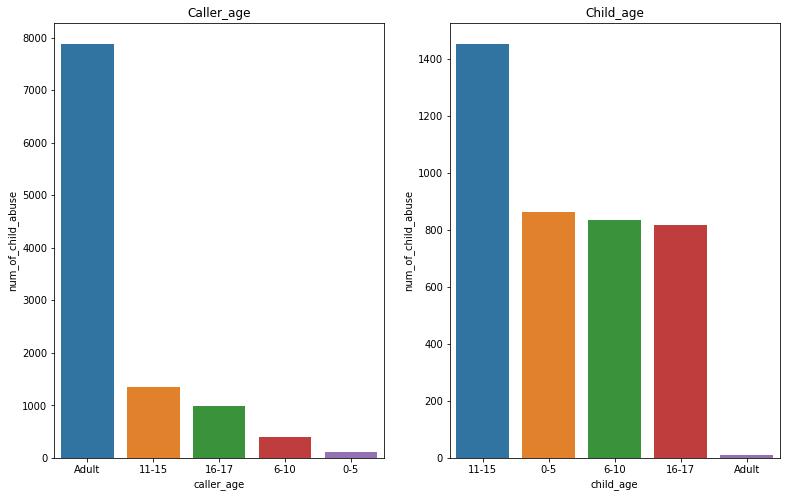

In [ ]:
#visualizing child_age column

fig , ax = plt.subplots( figsize =(13,8),ncols = 2)

sns.countplot(train_data.caller_age, order = train_data['caller_age'].value_counts().index, ax=ax[0]).set(title='Caller_age',ylabel = "num_of_child_abuse")

sns.countplot(train_data.child_age, order = train_data['child_age'].value_counts().index, ax=ax[1]).set(title='Child_age',ylabel = "num_of_child_abuse");


##### 4.2 Relationship between counties and child abuse

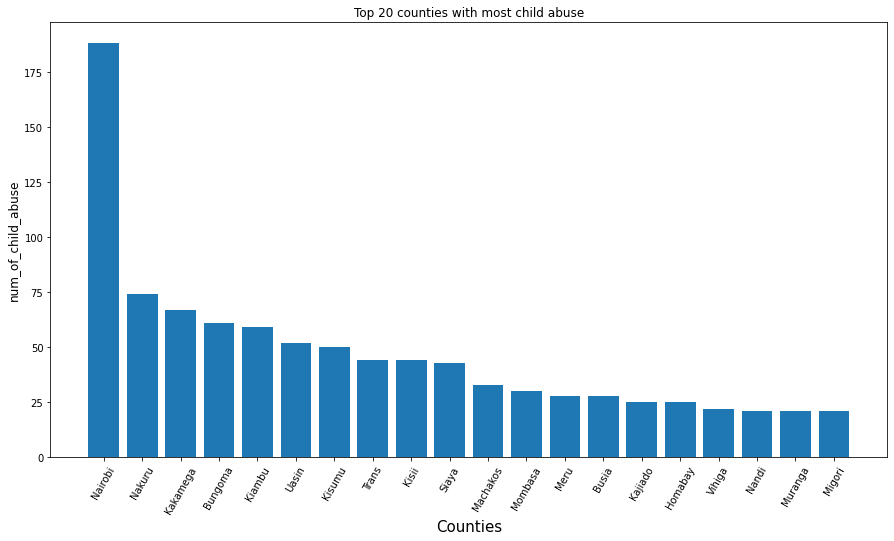

In [ ]:
#grouping data to get the top 20 counties.

grouped_data = train_data.groupby("child_county").count().sort_values(by = 'referal',ascending = False)
grouped_data.reset_index(inplace = True)
top_20_counties = grouped_data[:20]

#Ploting to 20 counties with high cases of child abuse

fig, ax = plt.subplots()

ax.bar(height = top_20_counties['referal'] , x=top_20_counties['child_county'] )
ax.tick_params(axis = "x",labelrotation = 60)
ax.set_title('Top 20 counties with most child abuse')
ax.set_xlabel('Counties',fontsize=15)
ax.set_ylabel('num_of_child_abuse',fontsize=12);


##### 4.3 Categories of child abuse

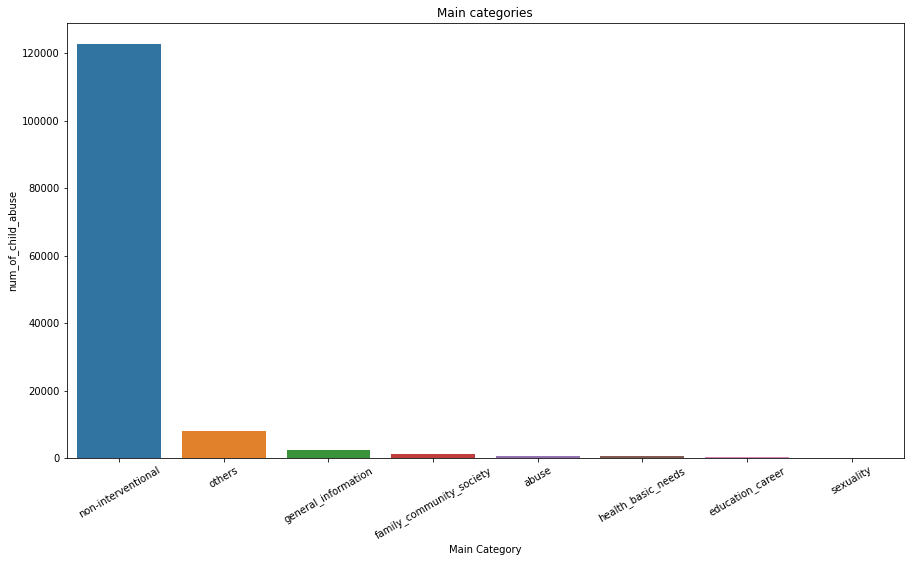

In [ ]:
fig , ax = plt.subplots()

sns.countplot(train_data.maincat, order = train_data['maincat'].value_counts().index)
plt.title('Main categories')
plt.xlabel('Main Category')
plt.ylabel('num_of_child_abuse')
ax.tick_params(axis = 'x',labelrotation = 30);

##### 4.4 Categories of child abuse without non-interventional category


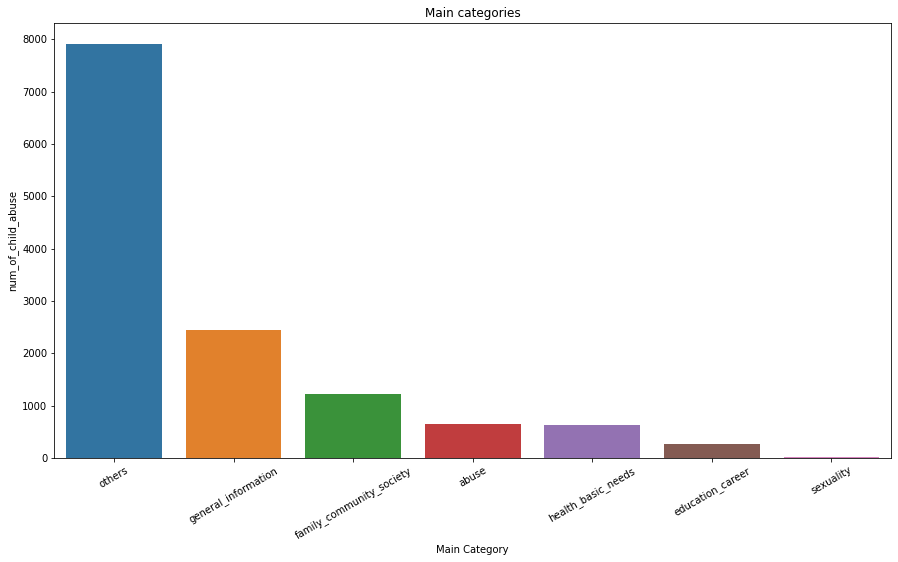

In [ ]:
#dropping non-interventional category

interventional = train_data[train_data['maincat'] != 'non-interventional']

#plotting main categories

train_data = train_data
fig , ax = plt.subplots()

sns.countplot(interventional.maincat, order = interventional['maincat'].value_counts().index)
plt.title('Main categories')
plt.xlabel('Main Category')
plt.ylabel('num_of_child_abuse')
ax.tick_params(axis = 'x',labelrotation = 30);

##### 4.5 Relationship between date and abuse

In [ ]:
train_data['calldate'].value_counts()

2016-04-01 10:21:00    9
2016-04-06 23:00:00    7
2016-04-07 08:47:00    6
2016-04-09 15:44:00    6
2016-04-06 16:33:00    5
                      ..
2016-02-23 22:44:08    1
2016-02-23 22:43:50    1
2016-02-23 22:42:00    1
2016-02-23 22:41:48    1
2016-07-12 23:57:28    1
Name: calldate, Length: 132382, dtype: int64

In [ ]:
#change calldata dtype to datetime

train_data.calldate = pd.to_datetime(train_data.calldate)

#remove seconds and minutes from time

train_data =train_data.assign(calldate=train_data.calldate.dt.round('H'))
train_data.head(2)

calldate cc_status             maincat     subcat1  casepriority  \
0 2016-01-01 07:00:00    Closed  non-interventional  Blank call  Non Critical   
1 2016-01-01 08:00:00    Closed  non-interventional  Blank call  Non Critical   

  referal caller_gender caller_age caller_county child_age child_gender  \
0     NaN           NaN        NaN           NaN       NaN          NaN   
1     NaN           NaN        NaN           NaN       NaN          NaN   

  child_county parent_age parent_gender parent_county Abuser_Relationship  \
0          NaN        NaN           NaN           NaN                 NaN   
1          NaN        NaN           NaN           NaN                 NaN   

  Neglector_Relationship Perpetrator_Relationship Physical abuser_Relationship  
0                    NaN                      NaN                          NaN  
1                    NaN                      NaN                          NaN

In [ ]:
#spliting calldate column into date and time

train_data['Dates'] = pd.to_datetime(train_data['calldate']).dt.date
train_data['Time'] = pd.to_datetime(train_data['calldate']).dt.time
train_data['Dates'].value_counts()

2016-07-06    1916
2016-07-07    1895
2016-07-08    1865
2016-07-11    1861
2016-07-12    1493
              ... 
2016-04-29     146
2016-04-17      97
2016-04-03      29
2016-07-13      21
2016-04-19       9
Name: Dates, Length: 188, dtype: int64

In [ ]:
#Ploting the top 30 dates with most child abuse
fig , ax = plt.subplots()
top_20_dates = train_data['Dates'].value_counts()[:30].plot(kind='bar')
ax.tick_params(axis = "x",labelrotation = 75)
ax.set_title('Top 30 dates with most child abuse')
ax.set_xlabel('Dates')
ax.set_ylabel('num_of_child_abuse')


Text(0, 0.5, 'num_of_child_abuse')

Text(0, 0.5, 'num_of_child_abuse')

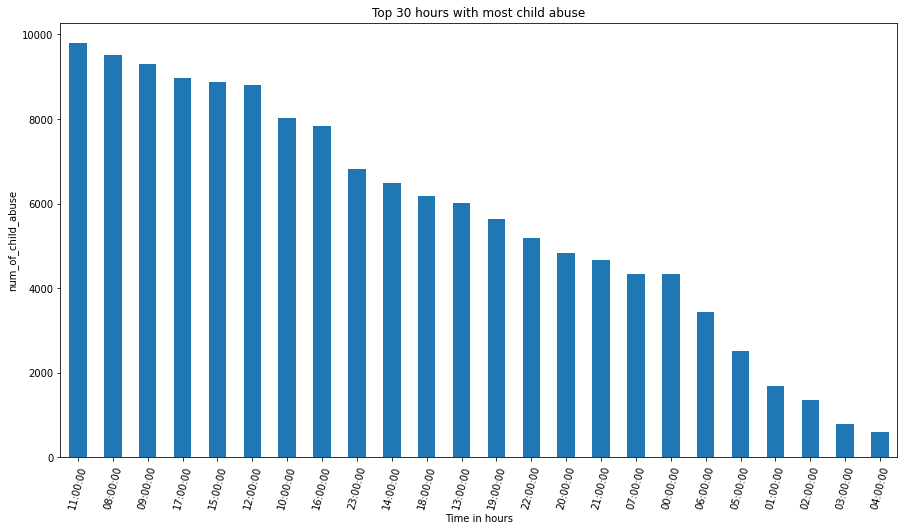

In [ ]:
#Ploting the top 30 day times with most child abuse
fig , ax = plt.subplots()
top_20_dates = train_data['Time'].value_counts()[:30].plot(kind='bar')
ax.tick_params(axis = "x",labelrotation = 75)
ax.set_title('Top 30 hours with most child abuse')
ax.set_xlabel('Time in hours')
ax.set_ylabel('num_of_child_abuse')


##### 4.6 Relationship between holiday and abuse

In [ ]:
holiday_data.value_counts()

Date        Holiday            
2016/01/01  New Years Day          1
2016/03/25  Good Friday            1
2016/03/28  Easter Monday          1
2016/05/01  Labour Day             1
2016/05/02  Labour Day observed    1
2016/06/01  Madaraka Day           1
2016/07/07  Eid Al Fitr            1
2016/09/11  Idd-Ul-Adha            1
2016/10/20  Mashujaa Day           1
2016/12/12  Jamhuri Day            1
2016/12/25  Christmas Day          1
2016/12/26  Boxing Day             1
2016/12/27  Christmas Holiday      1
dtype: int64

In [ ]:
#importing datetime library
from datetime import datetime
#creating a day and month column
train_data["month"]=train_data["calldate"].apply(lambda x: datetime.strftime(x,"%b"))
train_data["day"]=train_data["calldate"].apply(lambda x: datetime.strftime(x,"%d"))

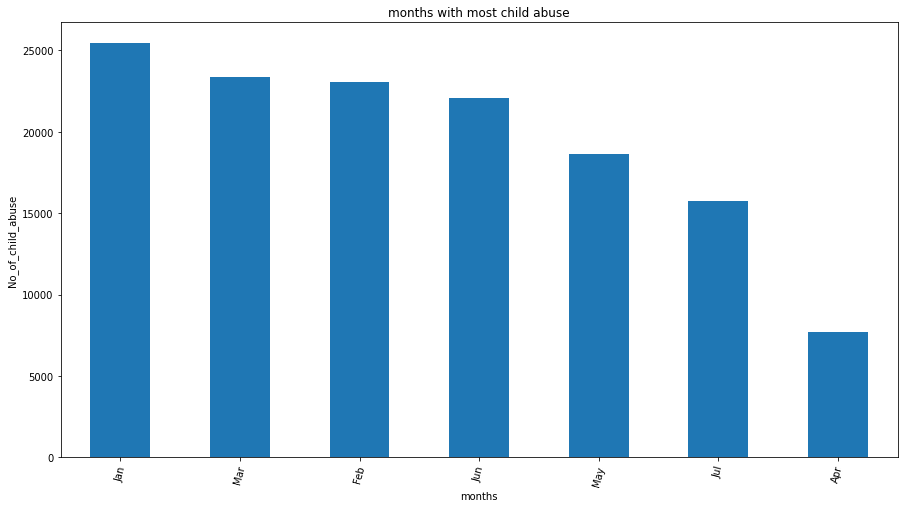

In [ ]:

#ploting months with most child abuse

fig , ax = plt.subplots(figsize = (15,8))

train_data['month'].value_counts().plot(kind='bar')
ax.tick_params(axis = "x",labelrotation = 75)
ax.set_title('months with most child abuse')
ax.set_xlabel('months')
ax.set_ylabel('No_of_child_abuse');

In [ ]:
#Identifying holidays using dates and months from holiday_data
pub_holiday=pd.Series([])
for i in range(len(train_data)):
    if train_data["month"][i]=="01" and train_data["day"][i]=="01":
        pub_holiday[i]="New Years"
    elif train_data["month"][i]=="03" and train_data["day"][i]=="25":
        pub_holiday[i]="Good Friday"
    elif train_data["month"][i]=="03" and train_data["day"][i]=="28":
        pub_holiday[i]="Easter Monday"
    elif train_data["month"][i]=="05" and train_data["day"][i]=="01":
        pub_holiday[i]="Labour Day"
    elif train_data["month"][i]=="05" and train_data["day"][i]=="02":
        pub_holiday[i]="Labour Day observed"
    elif train_data["month"][i]=="06" and train_data["day"][i]=="01":
        pub_holiday[i]="Madaraka Day"
    elif train_data["month"][i]=="07" and train_data["day"][i]=="07":
        pub_holiday[i]="Eid Al Fitr"
    elif train_data["month"][i]=="09" and train_data["day"][i]=="11":
        pub_holiday[i]="Idd-Ul-Adha"
    elif train_data["month"][i]=="10" and train_data["day"][i]=="20":
        pub_holiday[i]="Mashujaa Day"
    elif train_data["month"][i]=="12" and train_data["day"][i]=="12":
        pub_holiday[i]="Jamhuri Day"
    elif train_data["month"][i]=="12" and train_data["day"][i]=="25":
        pub_holiday[i]="Christmas Day"
    elif train_data["month"][i]=="12" and train_data["day"][i]=="26":
        pub_holiday[i]="Boxing Day"
    elif train_data["month"][i]=="12" and train_data["day"][i]=="27":
        pub_holiday[i]="Christmas Holiday"
    else :
        pub_holiday[i]="notholiday"




In [ ]:
#adding public holidays to the dataframe
train_data.insert(18,"pubHolidays",pub_holiday)
train_data.head(2)

calldate cc_status             maincat     subcat1  casepriority  \
0 2016-01-01 07:00:00    Closed  non-interventional  Blank call  Non Critical   
1 2016-01-01 08:00:00    Closed  non-interventional  Blank call  Non Critical   

  referal caller_gender caller_age caller_county child_age child_gender  \
0     NaN           NaN        NaN           NaN       NaN          NaN   
1     NaN           NaN        NaN           NaN       NaN          NaN   

  child_county parent_gender abuser_relationship       Dates      Time month  \
0          NaN           NaN                None  2016-01-01  07:00:00   Jan   
1          NaN           NaN                None  2016-01-01  08:00:00   Jan   

  day pubHolidays  
0  01  notholiday  
1  01  notholiday

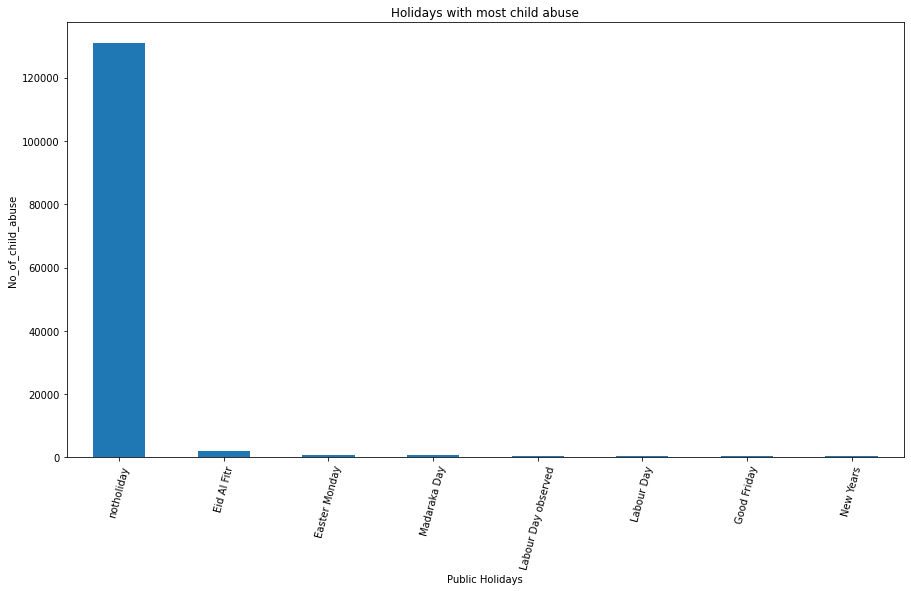

In [ ]:
#ploting holidays with most child abuse

fig , ax = plt.subplots()

train_data['pubHolidays'].value_counts().plot(kind='bar')
ax.tick_params(axis = "x",labelrotation = 75)
ax.set_title('Holidays with most child abuse')
ax.set_xlabel('Public Holidays')
ax.set_ylabel('No_of_child_abuse');

In [ ]:
# remove rows by filtering the non-holiday days
hol_day = train_data[train_data['pubHolidays'] != 'notholiday']
# display the dataframe
hol_day.head()

calldate cc_status             maincat  \
0 2016-01-01 07:00:00    Closed  non-interventional   
1 2016-01-01 08:00:00    Closed  non-interventional   
2 2016-01-01 08:00:00    Closed  non-interventional   
3 2016-01-01 08:00:00    Closed              others   
4 2016-01-01 08:00:00    Closed  non-interventional   

                               subcat1  casepriority referal caller_gender  \
0                           Blank call  Non Critical     NaN           NaN   
1                           Blank call  Non Critical     NaN           NaN   
2                           Blank call  Non Critical     NaN           NaN   
3  Unrelated to remit of Childline 116  Non Critical     NaN          Male   
4                           Blank call  Non Critical     NaN           NaN   

  caller_age caller_county child_age child_gender child_county parent_gender  \
0        NaN           NaN       NaN          NaN          NaN           NaN   
1        NaN           NaN       NaN          NaN          NaN           NaN   
2        NaN           NaN       NaN          NaN          NaN           NaN   
3      Adult         Nyeri       NaN          NaN          NaN           NaN   
4        NaN           NaN       NaN          NaN          NaN           NaN   

  abuser_relationship       Dates      Time month day pubHolidays  
0                None  2016-01-01  07:00:00    01  01   New Years  
1                None  2016-01-01  08:00:00    01  01   New Years  
2                None  2016-01-01  08:00:00    01  01   New Years  
3                None  2016-01-01  08:00:00    01  01   New Years  
4                None  2016-01-01  08:00:00    01  01   New Years

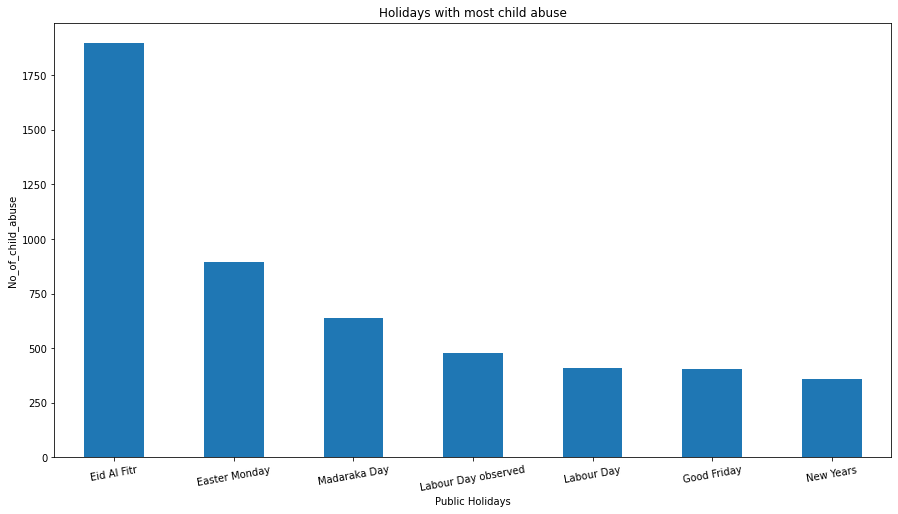

In [ ]:
#ploting holidays with most child abuse
fig , ax = plt.subplots()
hol_day['pubHolidays'].value_counts().plot(kind='bar')
ax.tick_params(axis = "x",labelrotation = 10)
ax.set_title('Holidays with most child abuse')
ax.set_xlabel('Public Holidays')
ax.set_ylabel('No_of_child_abuse');

##### 4.7 Relationship between School dates and abuse

In [ ]:
date_data.value_counts()

Term  Opening     Closing   
1     2016-01-04  2016-04-08    1
2     2016-05-02  2016-08-05    1
3     2016-09-05  2016-11-18    1
dtype: int64

In [ ]:
schdate=pd.Series([])
for i in range(len(train_data)):
     
    if train_data["month"][i]=="01" and (train_data["day"][i]=="01"):
        schdate[i]="notschooltime"
    elif train_data["month"][i]=="01" and (train_data["day"][i]=="02"):
        schdate[i]="notschooltime"
    elif train_data["month"][i]=="01" and (train_data["day"][i]=="03"):
        schdate[i]="notschooltime"
    
    elif train_data["month"][i]=="04" and train_data["day"][i]=="01" :
        schdate[i]="schooltime"
    elif train_data["month"][i]=="04" and (train_data["day"][i]=="02"):
        schdate[i]="schooltime"
    elif train_data["month"][i]=="04" and (train_data["day"][i]=="03"):
        schdate[i]="schooltime"
    elif train_data["month"][i]=="04" and (train_data["day"][i]=="04"):
        schdate[i]="schooltime"
    elif train_data["month"][i]=="04" and (train_data["day"][i]=="05"):
        schdate[i]="schooltime"
    elif train_data["month"][i]=="04" and (train_data["day"][i]=="06"):
        schdate[i]="schooltime"
    elif train_data["month"][i]=="04" and (train_data["day"][i]=="07"):
        schdate[i]="schooltime"
    elif train_data["month"][i]=="04" and (train_data["day"][i]=="08"):
        schdate[i]="schooltime"
    elif train_data["month"][i]=="04":
        schdate[i]="notschooltime"
    elif train_data["month"][i]=="05" and train_data["day"][i]=="01":
        schdate[i]="notschooltime"
    elif train_data["month"][i]=="05" and train_data["day"][i]!="01":
        schdate[i]="schooltime"
    else:
        schdate[i]="schooltime"
train_data.insert(19,"schooltimes",schdate)

In [ ]:
train_data[76000:78000]

calldate cc_status                   maincat  \
76000 2016-04-10 08:00:00    Closed        non-interventional   
76001 2016-04-10 08:00:00    Closed        non-interventional   
76002 2016-04-10 08:00:00    Closed        non-interventional   
76003 2016-04-10 08:00:00    Closed        non-interventional   
76004 2016-04-10 08:00:00    Closed        non-interventional   
...                   ...       ...                       ...   
77995 2016-04-22 09:00:00    Closed        non-interventional   
77996 2016-04-22 09:00:00  Referred  family_community_society   
77997 2016-04-22 09:00:00    Closed                    others   
77998 2016-04-22 09:00:00    Closed        non-interventional   
77999 2016-04-22 09:00:00    Closed                     abuse   

                        subcat1  casepriority                referal  \
76000               Silent call  Non Critical                    NaN   
76001               Silent call  Non Critical                    NaN   
76002               Silent call  Non Critical                    NaN   
76003                Blank call  Non Critical                    NaN   
76004               Silent call  Non Critical                    NaN   
...                         ...           ...                    ...   
77995               Silent call  Non Critical                    NaN   
77996     Maintenance & custody  Non Critical  children office/court   
77997  Insufficient information  Non Critical                    NaN   
77998                Blank call  Non Critical                    NaN   
77999              Sexual Abuse  Non Critical                    NaN   

      caller_gender caller_age caller_county child_age child_gender  \
76000           NaN        NaN           NaN       NaN          NaN   
76001           NaN        NaN           NaN       NaN          NaN   
76002           NaN        NaN           NaN       NaN          NaN   
76003           NaN        NaN           NaN       NaN          NaN   
76004           NaN        NaN           NaN       NaN          NaN   
...             ...        ...           ...       ...          ...   
77995           NaN        NaN           NaN       NaN          NaN   
77996        Female      Adult        Kiambu       0-5         Male   
77997        Female      Adult        Isiolo       NaN          NaN   
77998           NaN        NaN           NaN       NaN          NaN   
77999          Male      Adult       Makueni      6-10       Female   

      child_county parent_gender abuser_relationship       Dates      Time  \
76000          NaN           NaN                None  2016-04-10  08:00:00   
76001          NaN           NaN                None  2016-04-10  08:00:00   
76002          NaN           NaN                None  2016-04-10  08:00:00   
76003          NaN           NaN                None  2016-04-10  08:00:00   
76004          NaN           NaN                None  2016-04-10  08:00:00   
...            ...           ...                 ...         ...       ...   
77995          NaN           NaN                None  2016-04-22  09:00:00   
77996       Kiambu           NaN                None  2016-04-22  09:00:00   
77997          NaN           NaN                None  2016-04-22  09:00:00   
77998          NaN           NaN                None  2016-04-22  09:00:00   
77999      Makueni           NaN                None  2016-04-22  09:00:00   

      month day pubHolidays    schooltimes  
76000    04  10  notholiday  notschooltime  
76001    04  10  notholiday  notschooltime  
76002    04  10  notholiday  notschooltime  
76003    04  10  notholiday  notschooltime  
76004    04  10  notholiday  notschooltime  
...     ...  ..         ...            ...  
77995    04  22  notholiday  notschooltime  
77996    04  22  notholiday  notschooltime  
77997    04  22  notholiday  notschooltime  
77998    04  22  notholiday  notschooltime  
77999    04  22  notholiday  notschooltime  

[2000 rows x 20 columns]

In [ ]:
# Checking the first date
train_data["calldate"].min()


Timestamp('2016-01-01 07:00:00')

In [ ]:
# opening an closing dates
open_close_days = train_data[(train_data['calldate'] == '2016-01-04') | (train_data['calldate'] == '2016-04-08') | (train_data['calldate'] == '2016-05-02')]
# display the dataframe
open_close_days

calldate cc_status                   maincat  \
1098  2016-01-04    Closed        non-interventional   
1099  2016-01-04    Closed        non-interventional   
1100  2016-01-04    Closed        non-interventional   
1101  2016-01-04    Closed        non-interventional   
1102  2016-01-04    Closed        non-interventional   
1103  2016-01-04    Closed        non-interventional   
1104  2016-01-04    Closed        non-interventional   
1105  2016-01-04    Closed        non-interventional   
1106  2016-01-04      Open                 sexuality   
74765 2016-04-08    Closed        non-interventional   
74766 2016-04-08    Closed        non-interventional   
74767 2016-04-08    Closed        non-interventional   
74768 2016-04-08    Closed        non-interventional   
74769 2016-04-08    Closed        non-interventional   
74770 2016-04-08    Closed        non-interventional   
74771 2016-04-08    Closed        non-interventional   
74772 2016-04-08    Closed        non-interventional   
74773 2016-04-08    Closed        non-interventional   
74774 2016-04-08    Closed        non-interventional   
74775 2016-04-08    Closed        non-interventional   
74776 2016-04-08    Closed        non-interventional   
74777 2016-04-08    Closed        non-interventional   
74778 2016-04-08    Closed        non-interventional   
74779 2016-04-08    Closed        non-interventional   
74780 2016-04-08    Closed        non-interventional   
74781 2016-04-08    Closed        non-interventional   
74782 2016-04-08    Closed       general_information   
74783 2016-04-08    Closed        non-interventional   
74784 2016-04-08    Closed        non-interventional   
74785 2016-04-08    Closed        non-interventional   
74786 2016-04-08    Closed        non-interventional   
74787 2016-04-08    Closed        non-interventional   
74788 2016-04-08    Closed        non-interventional   
74789 2016-04-08    Closed        non-interventional   
74790 2016-04-08    Closed        non-interventional   
74791 2016-04-08    Closed                    others   
74792 2016-04-08  Referred  family_community_society   
74793 2016-04-08    Closed        non-interventional   
74794 2016-04-08    Closed        non-interventional   
79924 2016-05-02    Closed        non-interventional   
79925 2016-05-02    Closed        non-interventional   
79926 2016-05-02    Closed        non-interventional   
79927 2016-05-02    Closed        non-interventional   
79928 2016-05-02    Closed        non-interventional   
79929 2016-05-02    Closed        non-interventional   
79930 2016-05-02    Closed        non-interventional   
79931 2016-05-02    Closed        non-interventional   
79932 2016-05-02    Closed        non-interventional   
79933 2016-05-02    Closed        non-interventional   
79934 2016-05-02    Closed        non-interventional   
79935 2016-05-02    Closed        non-interventional   
79936 2016-05-02    Closed        non-interventional   
79937 2016-05-02    Closed        non-interventional   
79938 2016-05-02    Closed        non-interventional   
79939 2016-05-02    Closed        non-interventional   
79940 2016-05-02    Closed        non-interventional   
79941 2016-05-02    Closed        non-interventional   

                                   subcat1  casepriority  \
1098                           Silent call  Non Critical   
1099                           Silent call  Non Critical   
1100                           Silent call  Non Critical   
1101                           Silent call  Non Critical   
1102                           Silent call  Non Critical   
1103                            Blank call  Non Critical   
1104                           Silent call  Non Critical   
1105                           Silent call  Non Critical   
1106                   Reproductive health  Non Critical   
74765                          Silent call  Non Critical   
74766                          Silent call  Non Critical   
74767                          Silent c

Text(0, 0.5, 'No_of_child_abuse')

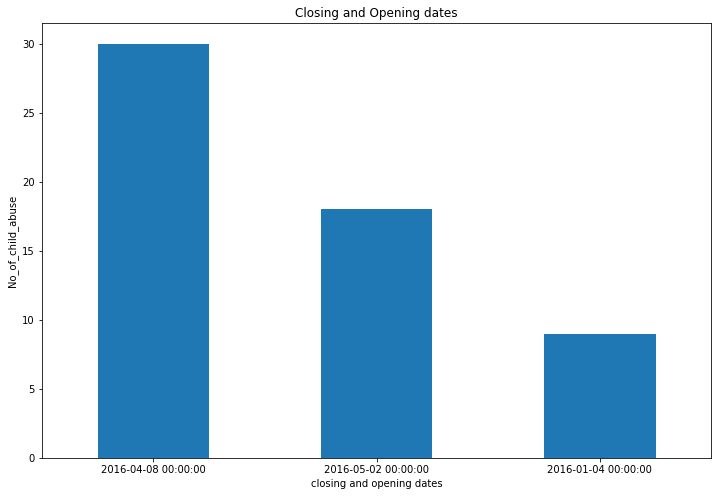

In [ ]:

# ploting a graph to check on opening and closing date
fig , ax = plt.subplots(figsize=(12,8))
graph = open_close_days['calldate'].value_counts().plot(kind='bar')
ax.tick_params(axis = "x",labelrotation = 0)
ax.set_title('Closing and Opening dates')
ax.set_xlabel('closing and opening dates')
ax.set_ylabel('No_of_child_abuse')



#### 4.8 Relationship between abuser and child

In [ ]:
train_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135988 entries, 0 to 135987
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   calldate             135988 non-null  datetime64[ns]
 1   cc_status            135988 non-null  object        
 2   maincat              135988 non-null  object        
 3   subcat1              135988 non-null  object        
 4   casepriority         135988 non-null  object        
 5   referal              1262 non-null    object        
 6   caller_gender        11548 non-null   object        
 7   caller_age           10732 non-null   object        
 8   caller_county        8667 non-null    object        
 9   child_age            3979 non-null    object        
 10  child_gender         3992 non-null    object        
 11  child_county         3749 non-null    object        
 12  parent_gender        69 non-null      object        
 13  abuser_relatio

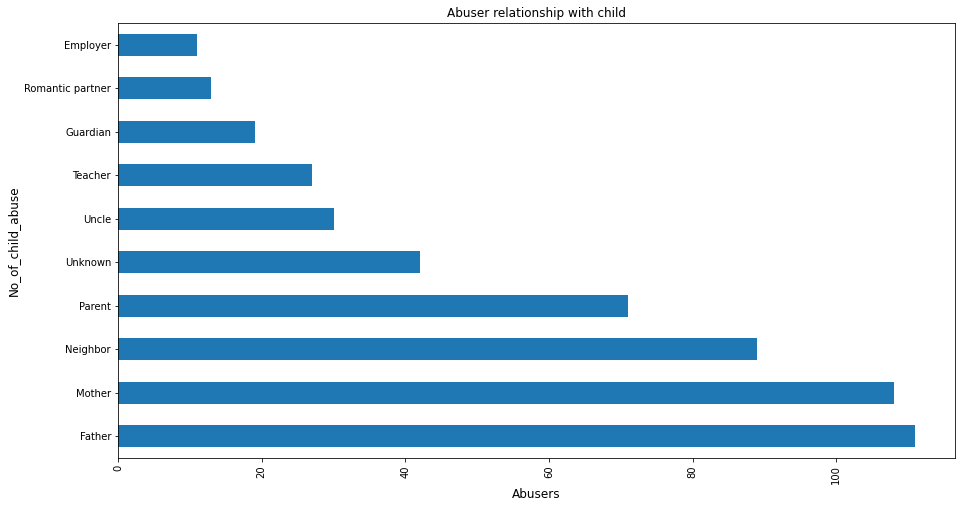

In [ ]:
#ploting top 10 abusers

fig , ax = plt.subplots()
train_data['abuser_relationship'].value_counts()[:10].plot(kind='barh')
ax.tick_params(axis = "x",labelrotation = 90)
ax.set_title('Abuser relationship with child')
ax.set_xlabel('Abusers',fontsize=12)
ax.set_ylabel('No_of_child_abuse',fontsize=12);

#### 4.9 Number of abuse cases  refered to different organizations

In [ ]:
#Ploting the referal
fig , ax = plt.subplots()
train_data['referal'].value_counts()[:10].plot(kind='barh')
ax.tick_params(axis = "x",labelrotation = 15)
ax.set_title('Referral')
ax.set_ylabel('No_of_child_abuse',fontsize=12);

#### 4.10 Call categories made

In [ ]:
#Ploting the call category

fig , ax = plt.subplots(figsize=(13,9))

train_data['subcat1'].value_counts()[:20].plot(kind='barh')
ax.tick_params(axis = "x",labelrotation = 90)
ax.set_title('call category')
ax.set_ylabel('No_of_child_abuse',fontsize=12);

#### 4.11 Relationship between gender and abuse

In [ ]:
train_data['child_gender'].value_counts()

Female     2065
Male       1921
Unknown       6
Name: child_gender, dtype: int64

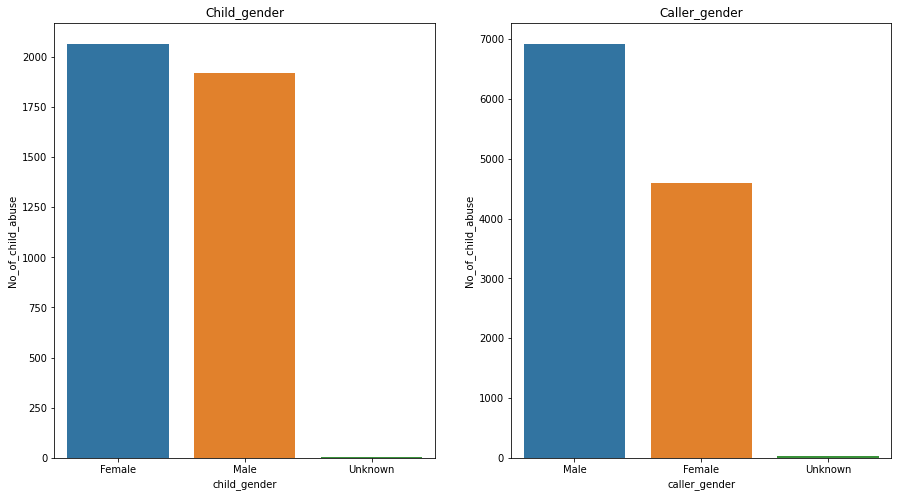

In [ ]:
fig, axs = plt.subplots(figsize=(15,8),ncols=2)

sns.countplot(train_data.child_gender, order = train_data['child_gender'].value_counts().index, ax=axs[0]).set(title='Child_gender',ylabel ='No_of_child_abuse')
sns.countplot(train_data.caller_gender, order = train_data['caller_gender'].value_counts().index, ax=axs[1]).set(title='Caller_gender',ylabel ='No_of_child_abuse');


# **5.0 PRE PROCESSING**

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135988 entries, 0 to 135987
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   calldate             135988 non-null  datetime64[ns]
 1   cc_status            135988 non-null  object        
 2   maincat              135988 non-null  object        
 3   subcat1              135988 non-null  object        
 4   casepriority         135988 non-null  object        
 5   referal              1262 non-null    object        
 6   caller_gender        11548 non-null   object        
 7   caller_age           10732 non-null   object        
 8   caller_county        8667 non-null    object        
 9   child_age            3979 non-null    object        
 10  child_gender         3992 non-null    object        
 11  child_county         3749 non-null    object        
 12  parent_gender        69 non-null      object        
 13  abuser_relatio

In [ ]:
ts_data = train_data.iloc[:,0:1]
ts_data.head()

calldate
0 2016-01-01 07:00:00
1 2016-01-01 08:00:00
2 2016-01-01 08:00:00
3 2016-01-01 08:00:00
4 2016-01-01 08:00:00

In [ ]:
for i in ts_data.calldate:

    def rounded_hours(time):
        # Rounds to nearest hour by adding a timedelta hour 
        return (time.replace(second=0, microsecond=0, minute=0, hour=time.hour)
                   +timedelta(hours=time.minute//60))


print(rounded_hours(i))

2016-07-13 00:00:00


In [ ]:
#applying the function to the calldate column

ts_data['ds'] = ts_data.apply(lambda x: rounded_hours(x['calldate']), axis=1)

In [ ]:
#assigning the call to each hour

ts_data.drop('calldate',axis=1,inplace=True)
ts_data.insert(1,value=1,column='call')
ts_data.head()

ds  call
0 2016-01-01 07:00:00     1
1 2016-01-01 08:00:00     1
2 2016-01-01 08:00:00     1
3 2016-01-01 08:00:00     1
4 2016-01-01 08:00:00     1

In [ ]:
ts_data['call'].value_counts()

1    135988
Name: call, dtype: int64

In [ ]:
ts_data = ts_data.groupby('ds').count().reset_index()#.rename(columns={'call':'y'})
ts_data.head()

ds  call
0 2016-01-01 07:00:00     1
1 2016-01-01 08:00:00    26
2 2016-01-01 09:00:00    32
3 2016-01-01 10:00:00    22
4 2016-01-01 11:00:00    53

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135988 entries, 0 to 135987
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   calldate             135988 non-null  datetime64[ns]
 1   cc_status            135988 non-null  object        
 2   maincat              135988 non-null  object        
 3   subcat1              135988 non-null  object        
 4   casepriority         135988 non-null  object        
 5   referal              1262 non-null    object        
 6   caller_gender        11548 non-null   object        
 7   caller_age           10732 non-null   object        
 8   caller_county        8667 non-null    object        
 9   child_age            3979 non-null    object        
 10  child_gender         3992 non-null    object        
 11  child_county         3749 non-null    object        
 12  parent_gender        69 non-null      object        
 13  abuser_relatio

In [ ]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3723 entries, 0 to 3722
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      3723 non-null   datetime64[ns]
 1   call    3723 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 58.3 KB


### **5.1 Test for stationarity**

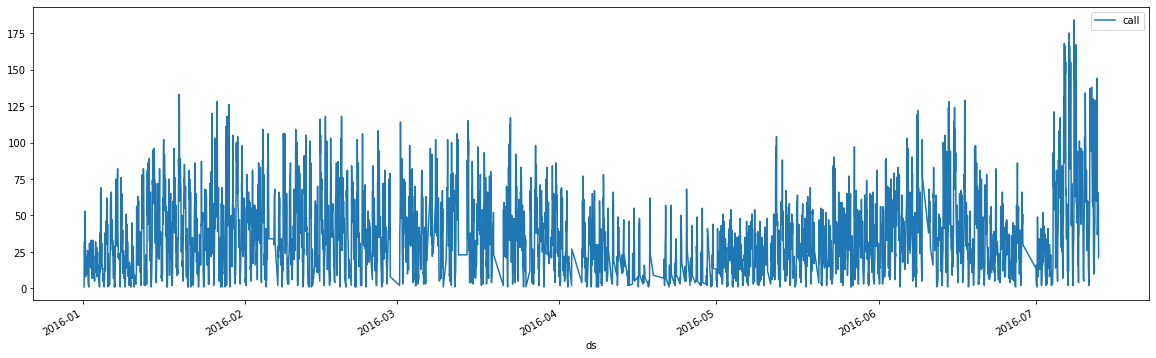

In [ ]:
ax = ts_data.plot(x='ds', y='call', figsize=(20,6))

In [ ]:
ts_data['ds'] = pd.to_datetime(ts_data['ds'])

# Set the 'Month' column as the index
ts = ts_data.set_index('ds')

In [ ]:
ts.head()

call
ds                       
2016-01-01 07:00:00     1
2016-01-01 08:00:00    26
2016-01-01 09:00:00    32
2016-01-01 10:00:00    22
2016-01-01 11:00:00    53

**Null Hypothesis**: Time series data is not stationary

In [ ]:
# a function to perform adfuller test

def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller Test
    dftest = adfuller(ts)
    # Plot rolling statistics:
    fig = plt.figure(figsize=(20,6))
    plt.plot(TS, color='blue',label='Original')
    plt.plot(roll_mean, color='red', label='Rolling Mean')
    plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

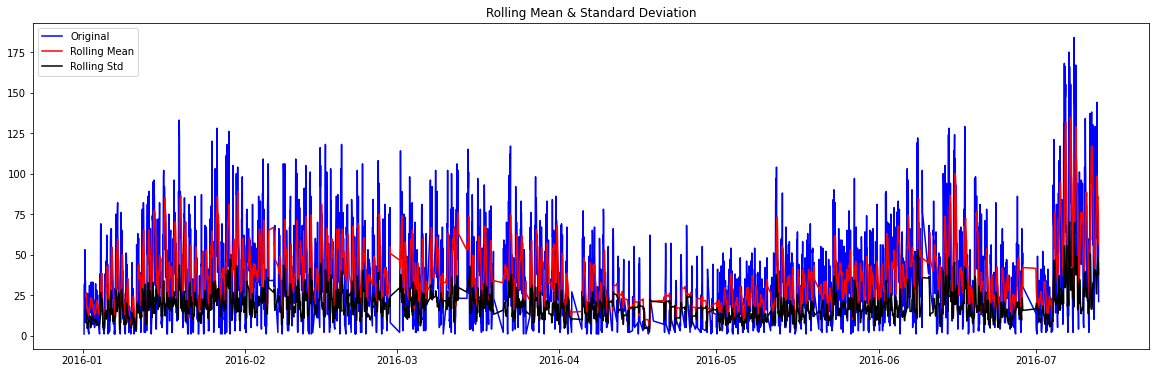

Results of Dickey-Fuller Test: 

Test Statistic                   -5.341144
p-value                           0.000004
#Lags Used                       28.000000
Number of Observations Used    3694.000000
Critical Value (1%)              -3.432121
Critical Value (5%)              -2.862323
Critical Value (10%)             -2.567187
dtype: float64


In [ ]:
stationarity_check(ts)

We reject the null hypothesis because the Test Statstic is less than the Critical Value and the p-value is less than 0.05. Therefore, we conclude our time series data is stationary

### **5.2 Test for Seasonality**

In [ ]:
#set figsize parameters
mpl.rcParams['figure.figsize'] = (16, 7) 

In [ ]:
additive_decomposition = seasonal_decompose(ts['call'], model='additive', period=30)
multiplicative_decomposition = seasonal_decompose(ts['call'], model='multiplicative', period=30)

In [ ]:
additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

If we look at the residuals of the additive decomposition closely, it has some pattern left over.

The multiplicative decomposition, looks quite random which is good. So ideally, multiplicative decomposition should be preferred for this particular series.



# **6.0 MODELING**

The ACF can answer some questions like:
 

*   Is the observed time series white noise / random?- non zero correlations show relationship between the data points 
*   Is an observation related to an adjacent observation or other points within it? 
*  Can the observed time series be modeled with an SARIMA model?

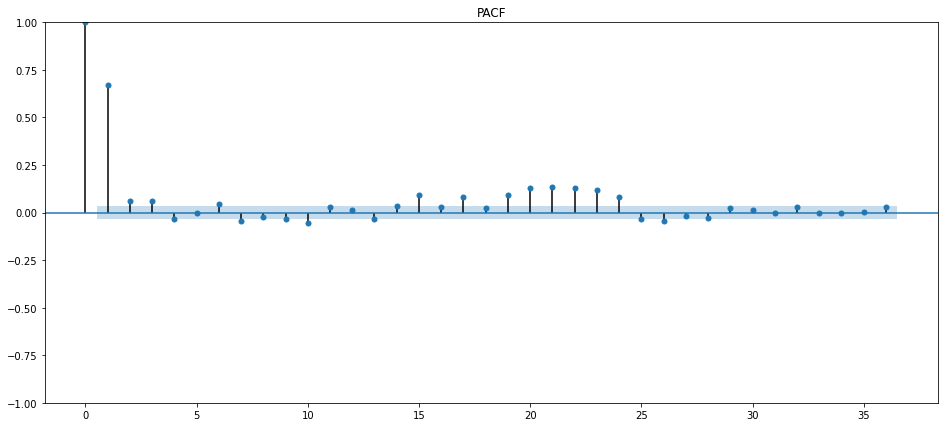

In [ ]:
acf_plot = plot_acf(ts, title="ACF")
pacf_plot = plot_pacf(ts, title="PACF")

#####**Findings**
*  There is autocorrelation in the time series at several lags. Therefore, the time series is non-random.There is also significant partial correlations which further continues to support that the series is not random

*  The ACF and PACF plots should be considered together to define the process. For the AR process, we expect that the ACF plot will gradually decrease and simultaneously the PACF should have a sharp drop after p significant lags. To define a MA process, we expect the opposite from the ACF and PACF plots, meaning that: the ACF should show a sharp drop after a certain q number of lags while PACF should show a geometric or gradual decreasing trend. On the other hand, if both ACF and PACF plots demonstrate a gradual decreasing pattern, then the ARMA process should be considered for modeling.

### **6.1 TIME SERIES MODELING**

In [ ]:
sarima_model = pm.auto_arima(ts, 
                             m=12,
                             seasonal=True,
                             start_p=0,
                             start_q=0,
                             start_P=0,
                             start_Q=0,
                             max_order=6, 
                             test='adf',
                             error_action='warn',  
                             suppress_warnings=True,
                            
                              stepwise=True,
                              trace=False)

In [ ]:
print(sarima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                 3723
Model:             SARIMAX(3, 0, 0)x(2, 0, 0, 12)   Log Likelihood              -16373.190
Date:                            Mon, 19 Sep 2022   AIC                          32760.379
Time:                                    12:16:16   BIC                          32803.935
Sample:                                         0   HQIC                         32775.875
                                           - 3723                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.5313      0.662     14.389      0.000       8.233      10.830
ar.L1          0.5791      0.015   

In [ ]:
p = d = q = range(0,2)

# Generate all different combinations of p, d , q and s
pdq = list(itertools.product(p, d, q))
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [ ]:
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

In [ ]:
ans = []
for comb in pdq:    
    for combs in seasonal_pdq:
        try:
            model = sm.tsa.statespace.SARIMAX(ts,
                                            order=comb,
                                            seasonal_order=combs,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            output = model.fit()
            ans.append([comb, combs, output.aic])
           
        except:
             continue

In [ ]:
ts_df = pd.DataFrame(ans, columns=['pdq','pdqs', 'aic'])
ts_df

pdq          pdqs           aic
0   (0, 1, 0)  (0, 1, 0, 7)  36117.842046
1   (0, 1, 0)  (0, 1, 1, 7)  33490.401507
2   (0, 1, 0)  (0, 1, 2, 7)  33431.232285
3   (0, 1, 0)  (1, 1, 0, 7)  35122.661647
4   (0, 1, 0)  (1, 1, 1, 7)  33491.403237
..        ...           ...           ...
76  (2, 1, 2)  (1, 1, 1, 7)  32748.781620
77  (2, 1, 2)  (1, 1, 2, 7)  32918.499673
78  (2, 1, 2)  (2, 1, 0, 7)  33605.723191
79  (2, 1, 2)  (2, 1, 1, 7)  32670.170409
80  (2, 1, 2)  (2, 1, 2, 7)  32640.738216

[81 rows x 3 columns]

In [ ]:
ts_df.loc[ts_df['aic'].idxmin()]

pdq        (1, 1, 2)
pdqs    (2, 1, 2, 7)
aic     32636.970472
Name: 53, dtype: object

There is an improvement in AIC, so we use the order parameters pdq and pdqs as shown above

In [ ]:
my_model = sm.tsa.statespace.SARIMAX(ts,
                                order=(1, 1, 2),
                                seasonal_order=(2, 1, 2, 7),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = my_model.fit()

print(results.summary())

The aic has improved. So lets check the distribution of residuals for this model

####**6.12 Model Diagnostic**

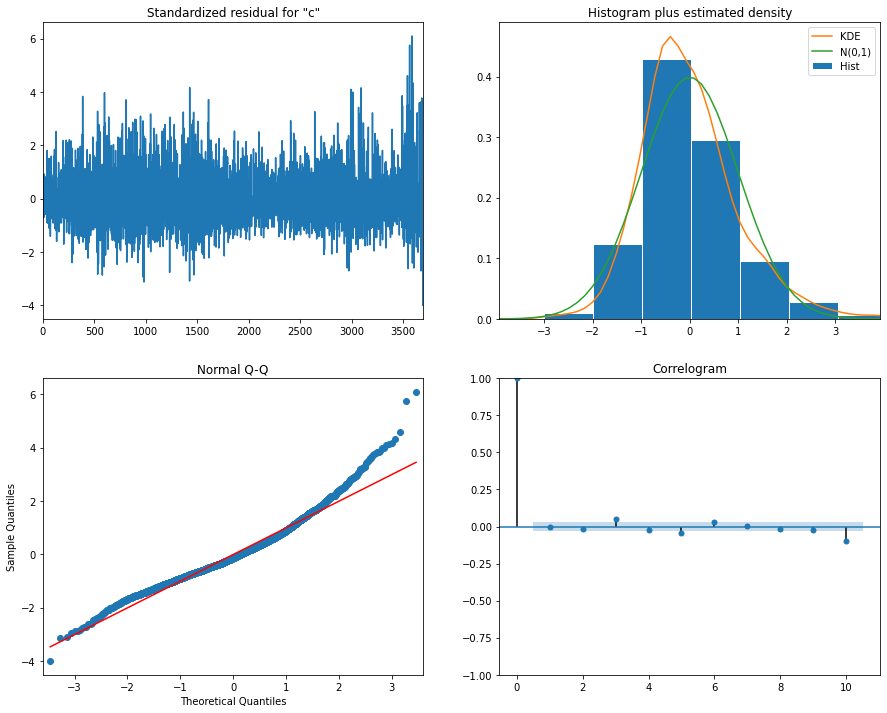

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

There is observed improvement in this new model. The AIC is lower, there is no correlation in the residuals and the Q-Q plot shows the residuals have been taken from a N(0,1). Also the histogram shows the distribution of the residuals with a mean of 0. So I will retain this model

##**6.2 Forecasting and Model Evaluation**

We compare predicted values to real values of the time series, which will help us understand the accuracy of our forecasts

In [ ]:
holidays = pd.DataFrame({
  'holiday': 'holiday',
  'ds': pd.to_datetime(['2016-01-01', '2016-03-25', '2016-03-28',
                        '2016-05-01', '2016-05-02', '2016-06-01',
                        '2016-07-07'])
})
school_off = pd.DataFrame({
    'holiday': 'school_off',
    'ds' : pd.to_datetime(['2016-01-02','2016-01-03','2016-04-09','2016-04-10','2016-04-11','2016-04-12','2016-04-13',
                          '2016-04-14','2016-04-15','2016-04-16','2016-04-17','2016-04-18','2016-04-19','2016-04-20',
                          '2016-04-21','2016-04-22','2016-04-23','2016-04-24','2016-04-25','2016-04-26','2016-04-27',
                          '2016-04-28','2016-04-29','2016-04-30','2016-08-06','2016-08-07','2016-08-08',
                           '2016-08-09','2016-08-10','2016-08-11','2016-08-12','2016-08-13','2016-08-14','2016-08-15',
                           '2016-08-16','2016-08-17','2016-08-18','2016-08-19','2016-08-20','2016-08-21','2016-08-22',
                           '2016-08-23','2016-08-24','2016-08-25','2016-08-26','2016-08-27','2016-08-28','2016-08-29',
                           '2016-08-30','2016-08-31','2016-09-01','2016-09-02','2016-09-03','2016-09-04'])
})

holidays=pd.concat((holidays,school_off))

In [ ]:
#reset index
ts.reset_index(inplace=True)

In [ ]:
#rename columns

ts.set_axis(['ds', 'y'],axis=1,inplace=True)

In [ ]:
#confirm column is renamed
ts.head()

ds   y
0 2016-01-01 07:00:00   1
1 2016-01-01 08:00:00  26
2 2016-01-01 09:00:00  32
3 2016-01-01 10:00:00  22
4 2016-01-01 11:00:00  53

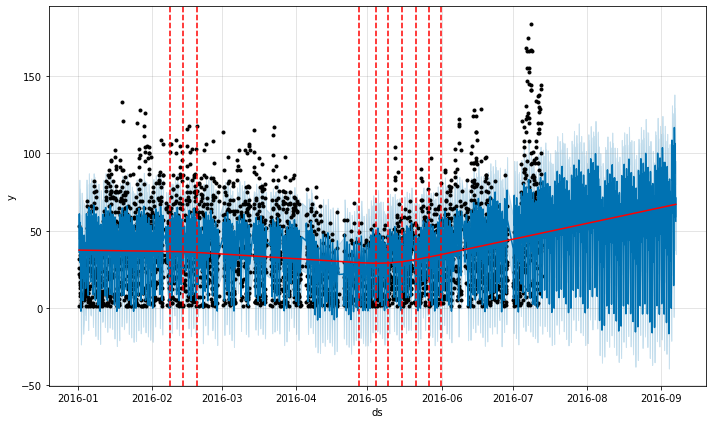

In [ ]:
calls = Prophet(changepoint_prior_scale=0.005, 
            changepoint_range=0.8,
            seasonality_mode='multiplicative',
            interval_width=0.7,
            holidays=holidays).fit(ts)
future = calls.make_future_dataframe(periods=1344, freq='H')
fcst = calls.predict(future)
fig = calls.plot(fcst)
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig.gca(),calls, fcst)

In [ ]:
print('Model Report:')
print()
fcst_y = fcst.loc[0:3722,['yhat']]
fcst_y = np.round(fcst_y).astype(int)
fcst_y = [0 if i<0 else i for i in fcst_y.yhat]
y = ts['y']
rmse_tr = sqrt(mean_squared_error(y, fcst_y))
print('Training RMSE:',rmse_tr)

Model Report:

Training RMSE: 20.747474434420443


##6.3 Cross Validating the Model

In [ ]:
ts_cv = cross_validation(calls, initial='2000 h', period='240 h', horizon = '48 h')
ts_cv.head()

  0%|          | 0/11 [00:00<?, ?it/s]

ds       yhat  yhat_lower  yhat_upper   y     cutoff
0 2016-04-02 01:00:00  15.384800   -6.425398   34.348963   5 2016-04-02
1 2016-04-02 02:00:00   4.480278  -16.126595   26.213378   7 2016-04-02
2 2016-04-02 03:00:00   1.373543  -18.672188   21.838829   9 2016-04-02
3 2016-04-02 04:00:00   5.577408  -15.128740   26.805701   8 2016-04-02
4 2016-04-02 05:00:00  13.394844   -7.967725   34.250327  23 2016-04-02

In [ ]:
from fbprophet.diagnostics import performance_metrics
ts_perf = performance_metrics(ts_cv)
ts_perf.tail()

horizon         mse       rmse        mae      mape     mdape  \
39 1 days 20:00:00  575.839683  23.996660  17.683252  0.446824  0.388335   
40 1 days 21:00:00  435.151023  20.860274  15.808214  0.506877  0.397804   
41 1 days 22:00:00  235.612424  15.349672  12.437548  0.508686  0.377589   
42 1 days 23:00:00  211.677980  14.549157  12.149942  0.823830  0.378590   
43 2 days 00:00:00  214.536369  14.647060  12.188384  0.961005  0.420528   

    coverage  
39  0.642857  
40  0.672619  
41  0.779762  
42  0.833333  
43  0.833333

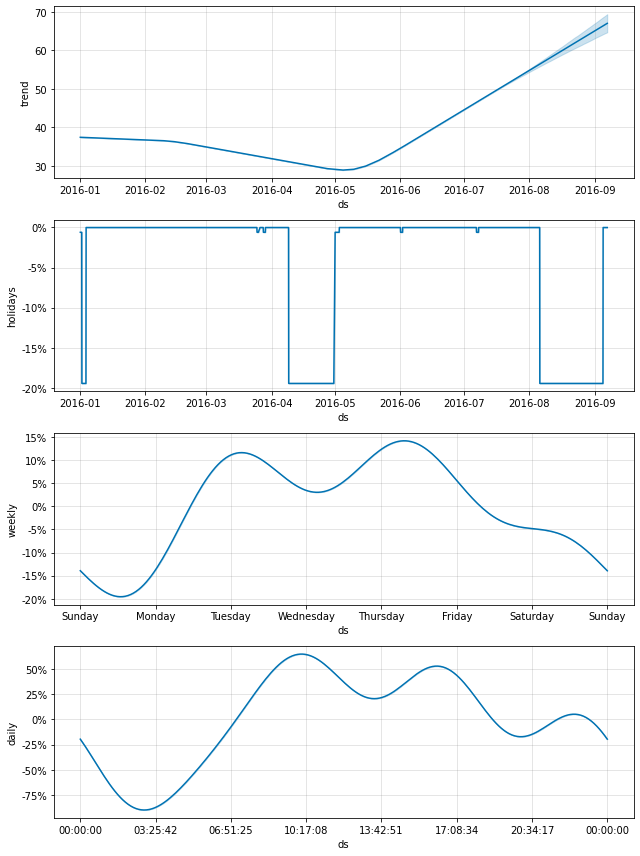

In [ ]:
calls.plot_components(fcst);

In [ ]:
forecasted_call_volume = fcst.loc[:,['ds','yhat_lower','yhat_upper','yhat']]
forecasted_call_volume.head()

ds  yhat_lower  yhat_upper       yhat
0 2016-01-01 07:00:00   13.379039   57.824975  36.115757
1 2016-01-01 08:00:00   26.024886   67.744584  47.328368
2 2016-01-01 09:00:00   35.170798   76.388541  56.849306
3 2016-01-01 10:00:00   38.448528   83.027488  60.906481
4 2016-01-01 11:00:00   36.252534   79.280564  57.708920

# **7.0 Conclusions**

### 7.1 EDA
1. Most calls were made by adults
2. Nairobi county reported the most cases of child abuse
3. Most cases of child abuse were reported during the month of July
4. Most calls on abuse were made at 11am
5. Fathers were reported to be the major abusers
6. Females were the most abused while males reported the most cases

## 7.2 Modelling
1. There's a rising trend in the call volume.
2. The impact of holidays on the call volume is clearly visible
3. Tuesday and Thursday were the busy days for Childline Kenya in terms of call volume.
4. The number of calls peaked between 10am and 4pm

# **8. Recomendations**

1. The peak days are: Tuesdays and Thursdays. Due to the overwhelming number of calls, blank calls are recorded. For this reason the Childline kenya should increase the number of call agents to handle number of blank calls especially on peak days.(blank calls-these are calls not picked by the agents or are picked but not responded to).
2. The Childline should visit schools to create awareness of child abuse by holding conferences to teach and remind the students of safety measures to take just before the students go for holidays and immediately when they return.
3.  The Childline needs to train staff on how to engage silent calls as the caller might be a child.
4.  Childline Kenya needs to sensitize children by carrying out teachings in schools and churches on how to relate with adults as most of the abusers happen to be people most closest to them